In [1]:
LEARNING_TYPE = "pointwise"
MODEL_CLASS = "DMF"
DATA_NAME = "movielens"
MODEL_NAME = f"{MODEL_CLASS}_{DATA_NAME}"

In [3]:
WORK_DIR_PATH = "../.."

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# WORK_DIR_PATH = "/content/drive/MyDrive/RS-DMF/"

# Constants

In [5]:
# split
TRN_NEG_PER_POS = 4
TST_NEG_PER_POS = 99
LOO_NEG_PER_POS = TST_NEG_PER_POS
TRN_BATCH_SIZE = 256
TST_BATCH_SIZE = TRN_BATCH_SIZE
LOO_BATCH_SIZE = 1000
TRN_VAL_TST_RATIO = dict(trn=0.8, val=0.1, tst=0.1)
NEG_PER_POS_RATIO = dict(trn=TRN_NEG_PER_POS, val=TRN_NEG_PER_POS, tst=TST_NEG_PER_POS, loo=LOO_NEG_PER_POS)
BATCH_SIZE = dict(trn=TRN_BATCH_SIZE, val=TRN_BATCH_SIZE, tst=TST_BATCH_SIZE, loo=LOO_BATCH_SIZE)
HIST_SELECTOR_TYPE = "tfidf"
MAX_HIST = 400 if HIST_SELECTOR_TYPE=="tfidf" else None
SHUFFLE = True

In [6]:
# Model
N_FACTORS = 32
HIDDEN = [N_FACTORS*8, N_FACTORS*4, N_FACTORS*2, N_FACTORS]
DROPOUT = 0.2

In [7]:
# how to learn
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-6

In [8]:
# how to monitor
METRIC_FN_TYPE = "ndcg"
PATIENCE = 5
DELTA = 1e-3

In [9]:
# how to loop
N_EPOCHS = 1000
WARM_UP = 10
INTERVAL = 1

# Config

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\REPO\PAPER REVIEW\RECSYS\02_MLP\02_RS-DMF


In [ ]:
import pandas as pd
import torch
from DMF import dmf
import UTILS
from PIPELINE.builder import Builder
from EXPERIMENT.runner import Runner
from EXPERIMENT.monitor.monitor import EarlyStoppingMonitor
from EXPERIMENT.evaluator.evaluator import PerformanceEvaluator

In [13]:
if LEARNING_TYPE=="listwise":
    from EXPERIMENT.trainer.listwise import CustomizedTrainer
    LOSS_FN_TYPE = "climf"

elif LEARNING_TYPE=="pairwise":
    from EXPERIMENT.trainer.pairwise import CustomizedTrainer
    LOSS_FN_TYPE = "bpr"

elif LEARNING_TYPE=="pointwise":
    from EXPERIMENT.trainer.pointwise import CustomizedTrainer
    LOSS_FN_TYPE = "bce"

else:
    raise ValueError()

In [14]:
from UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [15]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [16]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [17]:
data = pd.read_csv(f"./_data/{DATA_NAME}.csv")

In [18]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [19]:
# data Description
UTILS.datahandler.description(data)

number of user: 610
number of item: 9724
total interaction: 100836
interaction density: 1.7000 %
max interaction of user: 2698
max interaction of item: 329
top 10.0 % interaction of user: 400.3
top 10.0 % interaction of item: 27.0
mean interaction of user: 165
mean interaction of item: 10


In [ ]:
kwargs = dict(
    origin=data,
    learning_type=LEARNING_TYPE,
)

builder = Builder(**kwargs)

In [ ]:
kwargs = dict(
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos_ratio=NEG_PER_POS_RATIO,
    batch_size=BATCH_SIZE,
    hist_selector_type=HIST_SELECTOR_TYPE,
    max_hist=MAX_HIST,
    shuffle=SHUFFLE,
)

loaders, interactions, histories = builder(**kwargs)

# Modeling

In [22]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    hidden=HIDDEN,
    dropout=DROPOUT,
    interactions=interactions,
)

model = dmf.model.Module(**kwargs)

In [23]:
kwargs = dict(
    model=model,
    loss_fn_type=LOSS_FN_TYPE,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

trainer = CustomizedTrainer(**kwargs)

In [24]:
kwargs = dict(
    model=model,
    patience=PATIENCE,
    delta=DELTA,
    metric_fn_type=METRIC_FN_TYPE,
)

monitor = EarlyStoppingMonitor(**kwargs)

In [25]:
kwargs = dict(
    model=model,
    trainer=trainer,
    monitor=monitor,
)

runner = Runner(**kwargs)

# Train

In [26]:
kwargs = dict(
    trn_loader=loaders["trn"],
    val_loader=loaders["val"],
    loo_loader=loaders["loo"],
    n_epochs=N_EPOCHS,
    warm_up=WARM_UP,
    interval=INTERVAL,
)

history = runner.fit(**kwargs)

LEAVE ONE OUT
	BEST SCORE: 0.4469
	BEST EPOCH: 12
COMPUTING COST FOR LEARNING
	(s/epoch): 0.1941
	(epoch/s): 5.1520
	(s/batch): 0.0069
	(batch/s): 145.3187


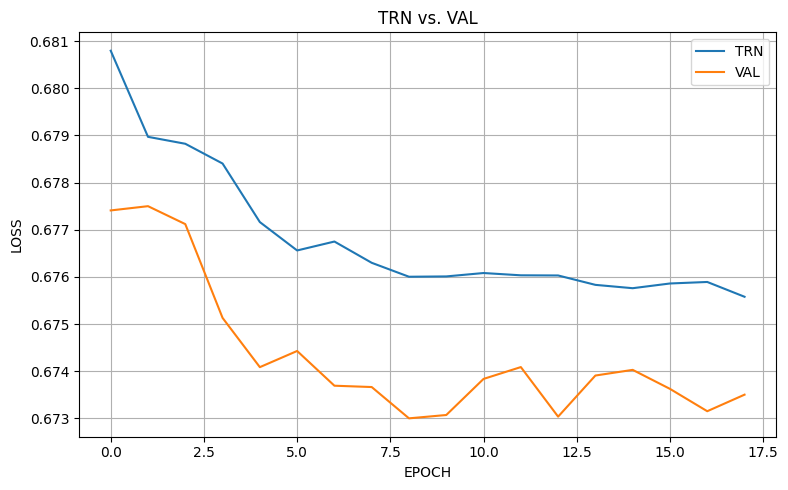

In [27]:
UTILS.visualizer.loss_plot(history, 'LOSS')

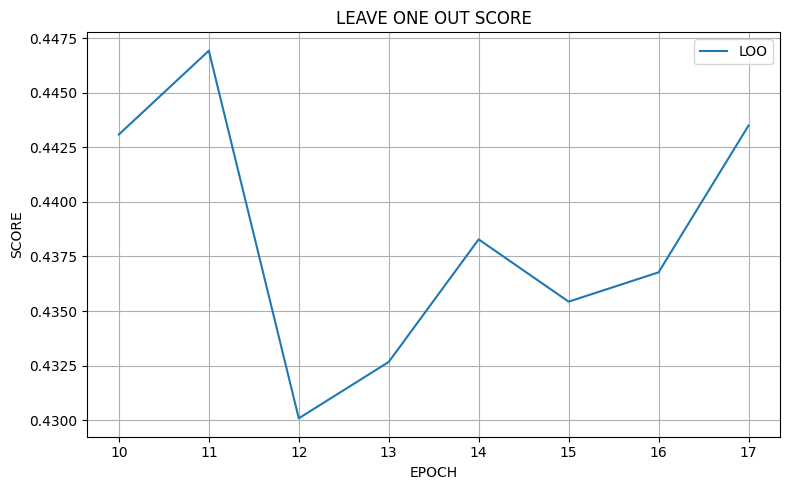

In [28]:
UTILS.visualizer.score_plot(history, 'SCORE')

# Test

In [29]:
evaluator = PerformanceEvaluator(model)

In [30]:
metrics_sheet = evaluator.evaluate(loaders["tst"])

COMPUTING COST FOR INFERENCE
	(s/epoch): 6.8451
	(epoch/s): 0.1461
	(s/batch): 0.0017
	(batch/s): 572.0878


In [31]:
metrics_sheet

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.657377,0.201311,0.173709,0.103105,0.238094
1,10,0.844262,0.184098,0.304496,0.139215,0.281574
2,15,0.924590,0.169180,0.393136,0.158130,0.312552
3,20,0.949180,0.154836,0.448343,0.169296,0.332027
4,25,0.962295,0.143213,0.489968,0.176825,0.346887
5,50,0.988525,0.107311,0.601435,0.195190,0.389176
6,100,0.998361,0.071525,0.689013,0.205486,0.420919


# Save

In [32]:
PATH = f'./_checkpoints/{LEARNING_TYPE}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)